In [ ]:
!nvidia-smi

Fri Jul 23 06:19:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Mounting the drive and copying the code from github to drive...anilaknb@gmail.com

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import re
import math
from functools import namedtuple
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [ ]:
file_path = '/content/gdrive/MyDrive/EVA6_P1_S10/sample_coco.txt'

columns = '''classes
             img_h
             img_w
             bb_x
             bb_y
             bb_h
             bb_w             
             n_bb_h
             n_bb_w
             log_bb_h
             log_bb_w
             '''

In [ ]:
def data_creation(file_path, columns):
    template_tup = namedtuple('template_tup', columns)
    collect_tup  = namedtuple('collect_tup', 'info')

    with open(file_path) as f:
       
        all_rows = f.readlines()
        for idx, row in enumerate(all_rows):
            '''
            Row format as below:
            id: 0, height: 330, width: 1093, bbox:[69, 464, 312, 175],
            '''
            if idx < len(all_rows) - 1: 
                row = re.sub('[a-z:]', '', row).replace('[', '').replace(']', '').replace('\n', '').split(',')[0:-1]
            else:            
                row = re.sub('[a-z:]', '', row).replace('[', '').replace(']', '').replace('\n', '').split(',')

            for i in range(len(row)):
                row[i]= int(row[i].strip())

            img_h, img_w, bb_h, bb_w = row[1], row[2], row[5], row[6]
            n_bb_h   = round(bb_h/img_h, 4)
            n_bb_w   = round(bb_w/img_w, 4)
            log_bb_h = round(math.log(n_bb_h), 4)
            log_bb_w = round(math.log(n_bb_w), 4)

            template = template_tup(*row, n_bb_h, n_bb_w, log_bb_h, log_bb_w)   
            if idx == 0:
                all_tup = collect_tup(template)
            else:
                all_tup += collect_tup(template)

            df = pd.DataFrame(data = all_tup)

    return df

In [ ]:
df = data_creation(file_path, columns)

In [ ]:
df[0:4]

,classes,img_h,img_w,bb_x,bb_y,bb_h,bb_w,n_bb_h,n_bb_w,log_bb_h,log_bb_w
0,0,330,1093,69,464,312,175,0.9455,0.1601,-0.0560,-1.8320
1,1,782,439,359,292,83,199,0.1061,0.4533,-2.2434,-0.7912
2,3,645,831,297,312,267,167,0.4140,0.2010,-0.8819,-1.6045
3,34,943,608,275,112,319,290,0.3383,0.4770,-1.0838,-0.7402


### To find the class distribution of coco test dataset

### As we can see classes are fairly balanced 

In [ ]:
class_list = sorted(list(df.classes.unique()))

class_dict = {}
for cls in class_list:
    class_dict[cls] = len(df[df['classes'] == cls])

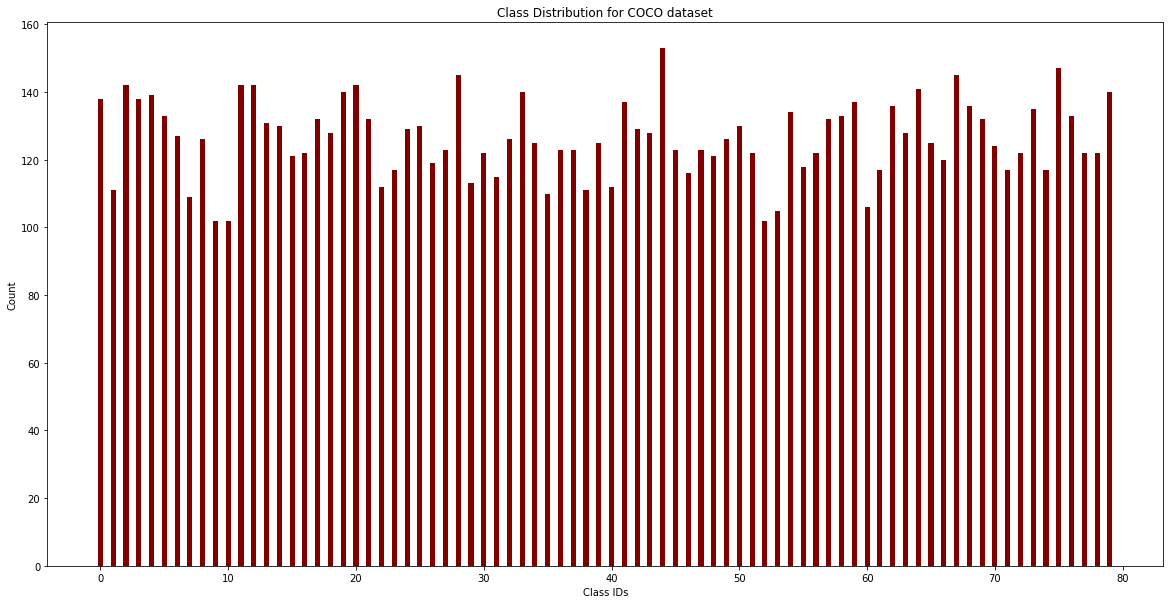

In [ ]:
class_ids = list(class_dict.keys())
counts = list(class_dict.values())
fig = plt.figure(figsize = (20, 10))
plt.bar(class_ids, counts, color ='maroon', width = 0.4)
plt.xlabel("Class IDs")
plt.ylabel("Count")
plt.title("Class Distribution for COCO dataset")
plt.show()

### Finding optimum number of clusters using K-Means for the log-normalized bounding box width and height

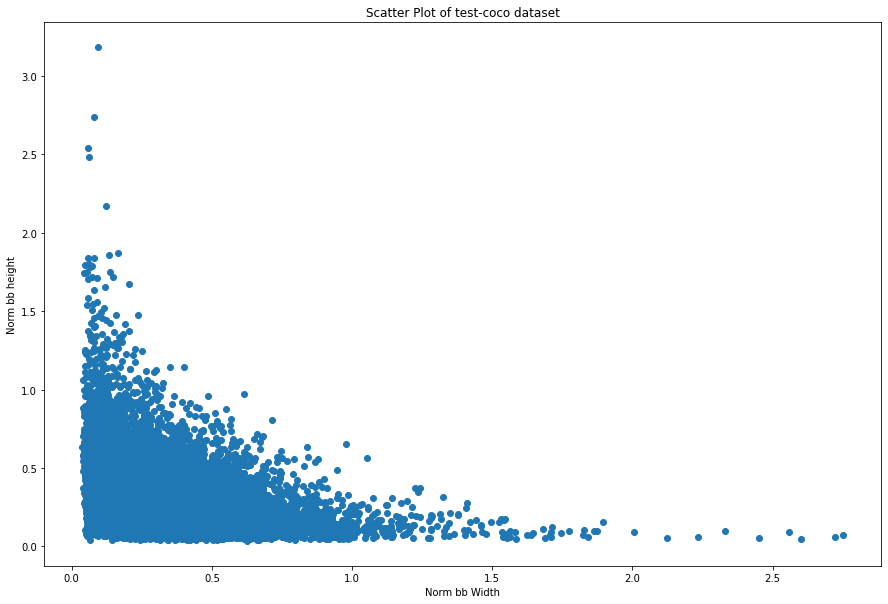

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(df['n_bb_w'], df['n_bb_h'])
plt.xlabel('Norm bb Width')
plt.ylabel('Norm bb height')
plt.title('Scatter Plot of test-coco dataset')
plt.show()

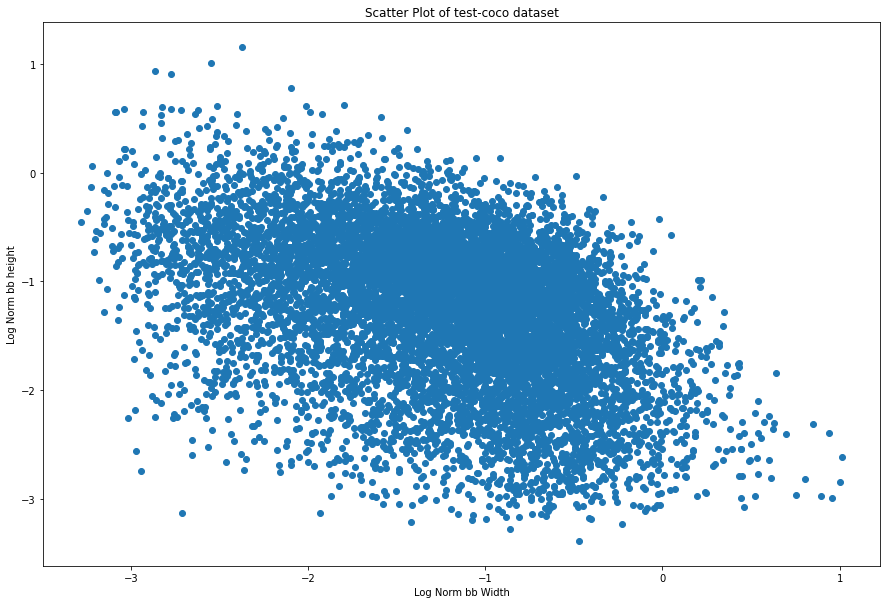

In [ ]:
plt.figure(figsize = (15, 10))
plt.scatter(df['log_bb_w'], df['log_bb_h'])
plt.xlabel('Log Norm bb Width')
plt.ylabel('Log Norm bb height')
plt.title('Scatter Plot of test-coco dataset')
plt.show()

In [ ]:
x = df[['log_bb_w', 'log_bb_h']].to_numpy()

In [ ]:
wcss = []  # Within-Cluster Sum of Square -> sum of squared distance between each point and the centroid in a cluster.

'''
The KMeans algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as
the inertia or within-cluster sum-of-squares.
Here we are trying out n=1 to 10 clusters to figure out which one is best
'''

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

#### n=3 seems to be the best with steepest slope, while n = 4 is also not a bad choice where n is the number of clusters (number of template boxes to be used)


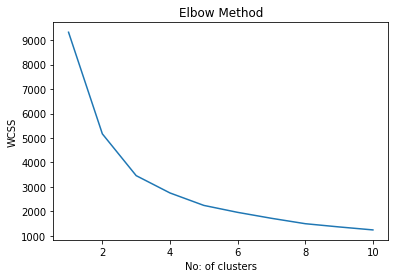

In [ ]:
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.xlabel('No: of clusters')
plt.ylabel('WCSS')
plt.show()

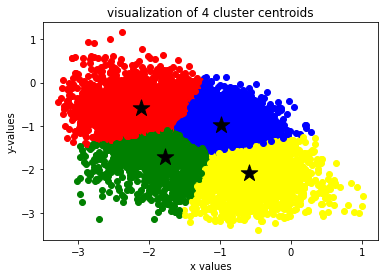

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
colors=['red', 'yellow', 'green', 'blue', 'orange']
pred_y = kmeans.fit_predict(x)
for i in range(len(pred_y)):
    plt.scatter(x[i,0],x[i,1],c=colors[pred_y[i]])
    plt.title('visualization of 4 cluster centroids')
    plt.xlabel('x values')
    plt.ylabel('y-values')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='black',marker='*')
plt.show()

### Scikit learn's k means does not allow us to provision our own distance metric. We need to use k-means via IOU distance metric. Hence let us use k-means based on pyclustering library which allows us to use cuctomized distance metric

In [ ]:
!pip install pyclustering

     |████████████████████████████████| 2.6 MB 42.6 MB/s 
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395121 sha256=c3b061359e63e4b4eb09ff571649b28aa1006fe6301b5d58569f467dd78c0104
  Stored in directory: /root/.cache/pip/wheels/ea/87/6b/1e0568b5ba9dc6518a25338bae90bd8392f35206bb90bb10f1
Successfully built pyclustering


#### IOU (Intersection Over Union) based Distance Metric IOU is a number between 0 and 1. The larger the better. Distance for k means should be (1 - IOU). 

In [ ]:
# given centroids find the maximum IOU of a bbox
def iou(box, centroids):
    x = np.minimum(np.exp(centroids[:, 0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroids[:, 1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroids[:, 0]) * np.exp(centroids[:, 1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    return (np.max(iou_), np.argmax(iou_))

In [ ]:
# given centroids find the maximum IOU of a bbox
def ioudist(box, centroid):
    x = np.minimum(np.exp(centroid[0]), np.exp(box[0]))
    y = np.minimum(np.exp(centroid[1]), np.exp(box[1]))

    intersection = x * y
    box_area = np.exp(box[0]) * np.exp(box[1])
    centroid_area = np.exp(centroid[0]) * np.exp(centroid[1])

    iou_ = intersection / (box_area + centroid_area - intersection)
    return 1 - iou_

In [ ]:
def plotIOU(X, Y):
    plt.scatter(X, Y)
    plt.plot(X, Y)
    plt.xlabel("centroid")
    plt.ylabel("mean maximum IOU")
    plt.xticks(np.arange(1, 11))
    plt.show()

#### Clustering K MEANS. We will store the clusters, centers & mean of max IOUs corresponding to each centroid.

In [ ]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils.metric import type_metric, distance_metric

In [ ]:
metric = distance_metric(type_metric.USER_DEFINED, func=ioudist) # Using IOU distance as metric

In [ ]:
clusters      = []
final_centers = []
mean_iou      = []

for k in range(1, 11):

    # Prepare initial centers using K-Means++ method.
    initial_centers = kmeans_plusplus_initializer(x, k).initialize()

    if k==1:
        kmeans_instance = kmeans(x, initial_centers)     
    else: 
        kmeans_instance = kmeans(x, initial_centers, metric=metric)

    kmeans_instance.process()
    clusters.append(kmeans_instance.get_clusters())
    center = np.array(kmeans_instance.get_centers())
    final_centers.append(center)

    maxiou = np.array([iou(box_dim, center)  for box_dim in x])
    mean_iou.append(np.mean(maxiou[:, 0]))

In [ ]:
len(clusters), len(final_centers), len(mean_iou)

(10, 10, 10)

### Checking **clusters** to get an intuition on how K-means worked in above section of code


In [ ]:
# We can see how clusters are increased from 1 to 10 & total number of bbox coodrinates (10_105), getting redistributed
for k in range(len(clusters)):
    length = len(clusters[k])
    print(f'**k = {k+1}, No: of clusters = {length}**')
    for cluster_num in range(length):
        print(f'    Cluster Number = {cluster_num+1}, No: of elements = {len(clusters[k][cluster_num])}')    

**k = 1, No: of clusters = 1**
    Cluster Number = 1, No: of elements = 10105
**k = 2, No: of clusters = 2**
    Cluster Number = 1, No: of elements = 4706
    Cluster Number = 2, No: of elements = 5399
**k = 3, No: of clusters = 3**
    Cluster Number = 1, No: of elements = 2778
    Cluster Number = 2, No: of elements = 2860
    Cluster Number = 3, No: of elements = 4467
**k = 4, No: of clusters = 4**
    Cluster Number = 1, No: of elements = 2296
    Cluster Number = 2, No: of elements = 2006
    Cluster Number = 3, No: of elements = 1565
    Cluster Number = 4, No: of elements = 4238
**k = 5, No: of clusters = 5**
    Cluster Number = 1, No: of elements = 1554
    Cluster Number = 2, No: of elements = 3104
    Cluster Number = 3, No: of elements = 1476
    Cluster Number = 4, No: of elements = 1496
    Cluster Number = 5, No: of elements = 2475
**k = 6, No: of clusters = 6**
    Cluster Number = 1, No: of elements = 1260
    Cluster Number = 2, No: of elements = 2766
    Cluster Nu

### Checking **final_centers** also to get an intuition on how K-means worked in above section of code. Each cluster is centered around each of these centers.

In [ ]:
# We will start with 1 initial center for k = 1
# For k = 2, We will identify 1 more center & readjust the earlier center according to new clustering
# Similary for k = 3, we will identify 1 more center & readjust the earlier centers as per new clusters
# This will keep on going till we reach k = 10 bcoz we are executing 'for' loop for k = 1 to 10

for idx, center in enumerate(final_centers):
    if idx < 3:
        print(f' k = {idx+1}, No:of centers = {len(center)}, Center = {center}')
    else:
        print(f' k = {idx+1}, No:of centers = {len(center)}')

 k = 1, No:of centers = 1, Center = [[-1.23190857 -1.25724471]]
 k = 2, No:of centers = 2, Center = [[-1.79131124 -0.89757811]
 [-0.74430921 -1.57074555]]
 k = 3, No:of centers = 3, Center = [[-2.10368402 -0.87233531]
 [-0.79719909 -2.09666042]
 [-0.96807981 -0.95918099]]
 k = 4, No:of centers = 4
 k = 5, No:of centers = 5
 k = 6, No:of centers = 6
 k = 7, No:of centers = 7
 k = 8, No:of centers = 8
 k = 9, No:of centers = 9
 k = 10, No:of centers = 10


#### Checking **mean_iou** also to get an intuition on how K-means worked in above section of code. 


In [ ]:
for idx, item in enumerate(mean_iou):
    print(f'k = {idx+1}, mean_iou = {mean_iou[idx]}')

k = 1, mean_iou = 0.4266264742620292
k = 2, mean_iou = 0.5039061350724818
k = 3, mean_iou = 0.5657788457134559
k = 4, mean_iou = 0.5907679265161058
k = 5, mean_iou = 0.6199510025861401
k = 6, mean_iou = 0.6343539217367106
k = 7, mean_iou = 0.6561327448165396
k = 8, mean_iou = 0.6717950188840406
k = 9, mean_iou = 0.6847187732186609
k = 10, mean_iou = 0.6955084719074457


#### Let us plot mean_iou corresponding to eack 'k' value

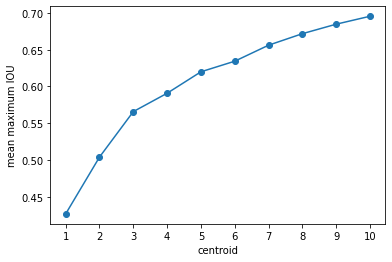

In [ ]:
plotIOU(range(1,11), mean_iou)

### Steepest jump interms of IOU seems to be till k = 3 but k = 4 also seems fine. So let us  plot top-3 & top-4 Anchor boxes 

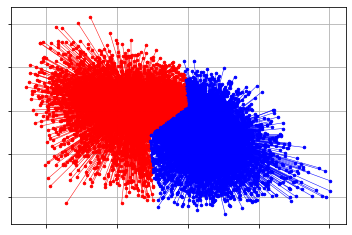

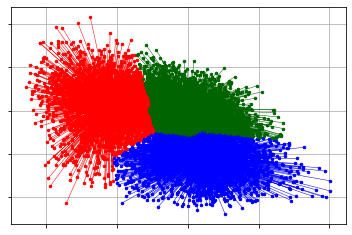

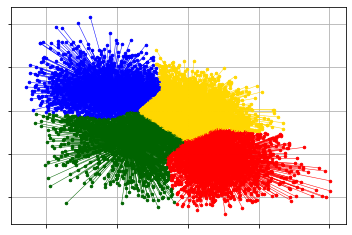

In [ ]:
for k in [1, 2, 3]:   # k = 2 means 3 clusters
  kmeans_visualizer.show_clusters(x, clusters[k], final_centers[k])

In [ ]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

def make_anchor_boxes(ax, clusters, facecolor='None', edgecolor='b', alpha=1):

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerror = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(clusters[:, 1])/2)]*2)
    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata, ydata, xerr=xerror, yerr=yerror,
                          fmt='None', ecolor='None')

    return artists

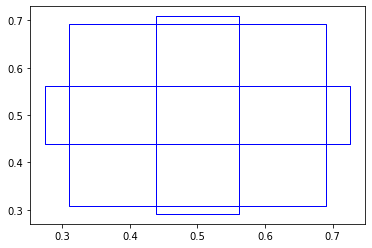

In [ ]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Call function to create bounding box templates. Choosing final_centers[2] because because we are plotting bb for k = 3
_ = make_anchor_boxes(ax, final_centers[2])

plt.show()

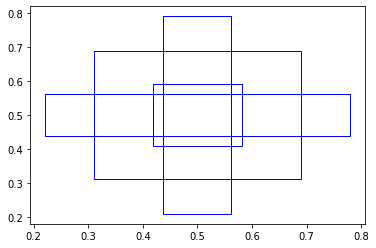

In [ ]:
# Create figure and axes
fig, ax = plt.subplots(1)

# Call function to create bounding box templates. Choosing final_centers[3] because we are plotting bb for k = 4
_ = make_anchor_boxes(ax, final_centers[3])

plt.show()